In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

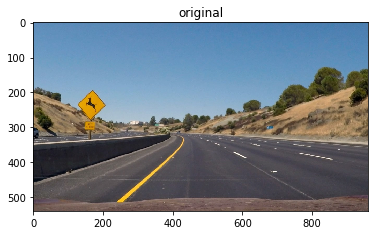

In [2]:
image = mpimg.imread('test_images/test2.jpg')
image = cv2.resize(image, (960, 540))
plt.imshow(image)
plt.title('original')

In [3]:
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

In [4]:
image_ud = undistort_image(image, mtx_camera, dist_camera)

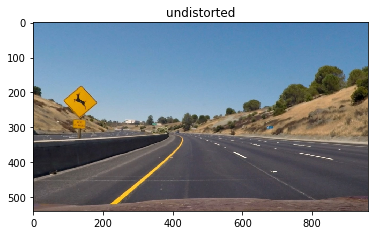

In [5]:
plt.imshow(image_ud)
plt.title('undistorted')

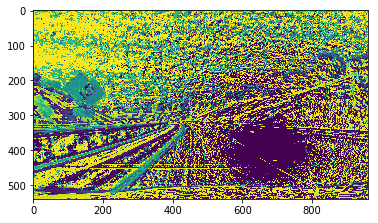

In [6]:
plt.imshow(np.sum((image-image_ud), axis=2))

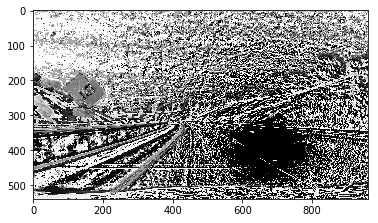

In [7]:
plt.imshow(np.sum((image-image_ud), axis=2),cmap='gray')

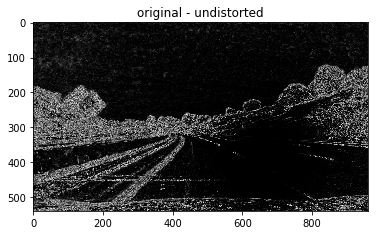

In [8]:
plt.imshow(np.sum((image-image_ud)**2, axis=2),cmap='gray')
plt.title('original - undistorted')

### Apply perspective transform

In [9]:
def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

In [10]:
image = image_ud

In [11]:
img_size = np.shape(image) # 画像を行列に変換する。

In [12]:
print(img_size[0],img_size[1])

540 960


In [13]:
# unitとは符号なしの整数。確かにprint結果を見ても整数である。
#左上を(0,0)とする
#img_size[0]は列
#img_size[1]は行
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - 1*np.uint(img_size[1]/2)
cbr_window = c_window + 1*np.uint(img_size[1]/2)

In [14]:
print(ht_window,hb_window,c_window,ctl_window,ctr_window,cbl_window,cbr_window)

360 540 480 384.0 576.0 0 960


In [15]:
src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

In [16]:
print(src) # Bird-eye view point

[[   0.  540.]
 [ 960.  540.]
 [ 576.  360.]
 [ 384.  360.]]


In [17]:
dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

In [18]:
print(dst) # Bird-eyeで得られた画像をさらに同じ画像サイズの行列式に変換する。

[[   0.  540.]
 [ 960.  540.]
 [ 960.    0.]
 [   0.    0.]]


In [19]:
warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

In [20]:
print(warped,M_warp,Minv_warp)

[[[ 88  82  86]
  [ 88  82  86]
  [ 88  82  86]
  ..., 
  [ 90  85  93]
  [ 90  85  94]
  [ 90  84  94]]

 [[ 88  82  86]
  [ 88  82  86]
  [ 88  82  86]
  ..., 
  [ 90  85  94]
  [ 90  85  94]
  [ 90  84  94]]

 [[ 88  82  86]
  [ 88  82  86]
  [ 88  82  86]
  ..., 
  [ 90  85  94]
  [ 90  84  94]
  [ 90  84  94]]

 ..., 
 [[127 104  97]
  [127 104  98]
  [127 104  97]
  ..., 
  [ 98  79  73]
  [ 99  80  74]
  [ 98  79  73]]

 [[126 103  95]
  [126 103  95]
  [127 104  96]
  ..., 
  [ 99  80  74]
  [102  83  77]
  [102  84  78]]

 [[128 105  97]
  [129 106  98]
  [129 106  98]
  ..., 
  [100  81  75]
  [ 98  79  73]
  [ 97  78  72]]] [[ -7.14285714e-01  -1.52380952e+00   8.22857143e+02]
 [ -6.66133815e-15  -2.14285714e+00   7.71428571e+02]
 [ -1.29020059e-17  -3.17460317e-03   1.00000000e+00]] [[  2.00000000e-01  -7.11111111e-01   3.84000000e+02]
 [  2.22044605e-16  -4.66666667e-01   3.60000000e+02]
 [ -8.67361738e-19  -1.48148148e-03   1.00000000e+00]]


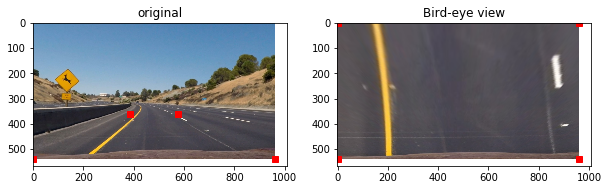

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs') # オリジナルの画像に4点をプロットする。rsはrectangle selector
plt.title('original')

plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs') # 4点を引き伸ばし、その画像を行列で拡大する。
    
plt.title('Bird-eye view')

### Apply color mask

In [22]:
def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

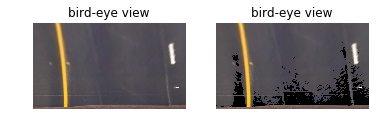

In [23]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

white_hsv_low = np.array([0,  0, 80])
white_hsv_high = np.array([255, 255, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');

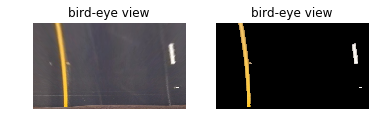

In [24]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

white_hsv_low = np.array([0,  0, 160])
white_hsv_high = np.array([255, 255, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');

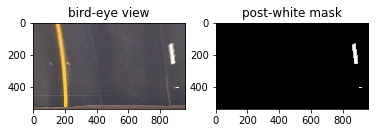

In [25]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

white_hsv_low = np.array([0,  0, 160])
white_hsv_high = np.array([255, 30, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('post-white mask')

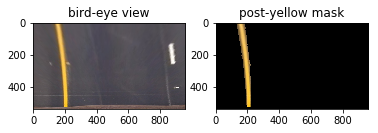

In [26]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])


res_mask = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)

res = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.subplot(1,2,2)
plt.imshow(res)
plt.title('post-yellow mask')

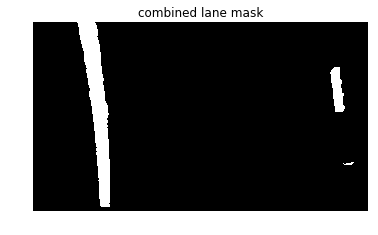

In [27]:
mask_yellow = color_mask(image_HSV, yellow_hsv_low, yellow_hsv_high)
mask_white  = color_mask(image_HSV, white_hsv_low , white_hsv_high)
mask_lane   = cv2.bitwise_or(mask_yellow, mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

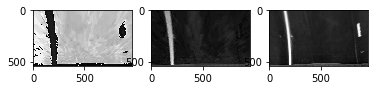

In [28]:
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')

### Apply sobel Fiters to L and S channels

In [29]:

kernel_size = 5

def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Apply Gaussian adaptive thresholding
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

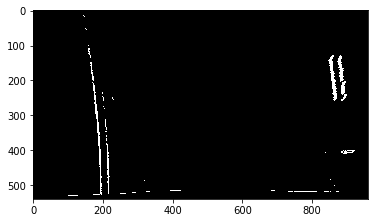

In [30]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',10,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',10,(80,225))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

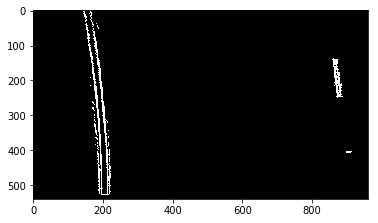

In [31]:
img_gs = image_HLS[:,:,2]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

In [32]:
wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

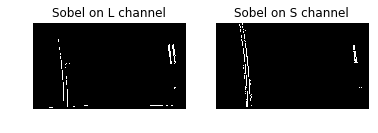

In [33]:
plt.subplot(1,2,1)
plt.imshow(wraped2,cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wraped3,cmap='gray')
plt.axis('off');

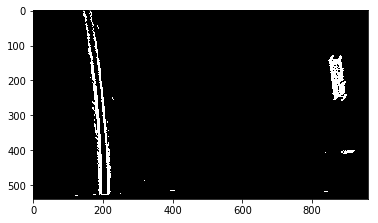

In [34]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
image_cmb = gaussian_blur(image_cmb,3)
plt.imshow(image_cmb,cmap='gray')

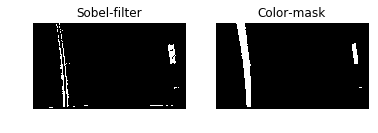

In [35]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
#image_cmb = cv2.bitwise_or(image_cmb,res)
#image_cmb = gaussian_blur(image_cmb,3)

image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1


plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')

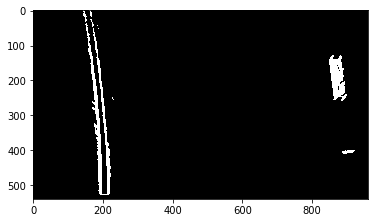

In [36]:
lane_line_gb = cv2.GaussianBlur(image_cmb,(9,9),0)
plt.imshow(lane_line_gb,cmap="gray")

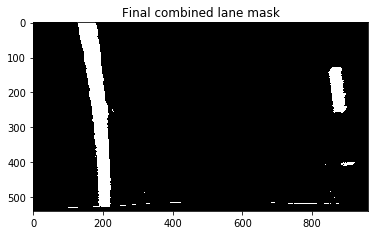

In [37]:
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')
plt.title('Final combined lane mask')

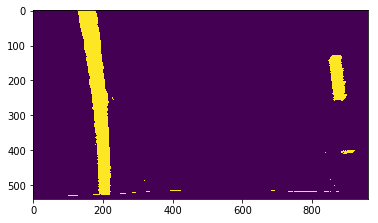

In [38]:
plt.imshow(image_cmb1)

### Lane Detection

In [39]:
from scipy.signal import find_peaks_cwt

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def initial_mask(img,window_size):
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = int(img_size[1]/50.)
    mean_lane = np.mean(img[img_size[1]//2:,:],axis=0)
    mean_lane = moving_average(mean_lane,mov_filtsize)

     #find peak indexes from histogram
    indexes = find_peaks_cwt(mean_lane,[100],max_distances=[800])
    
    
    val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    
    # exchange indexes if under condition
    if ind_peakR<ind_peakL:
        
        ind_peakR,ind_peakL = ind_peakL,ind_peakR

    # take windows from each index
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L = np.zeros_like(img)
    mask_R = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    # Split image into 11 parts and compute histogram on each part
    
    for i in range(11):
        img_y1 = int(img_size[0]-img_size[0]*i/11)
        img_y2 = int(img_size[0]-img_size[0]*(i+1)/11)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        # if the indexes are more than 2 (both side peak L,R)
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_peakR,ind_peakL = ind_peakL,ind_peakR
            
        else:
        # if one peak is found
            if len(indexes)==1:
                #found right lane 
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                # found left lane
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            # If no pixels are found, use previous ones. 
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
            
        # If new center is more than 80pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL-ind_peakL_prev)>=80:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=80:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.
        mask_R[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1.
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L,mask_R

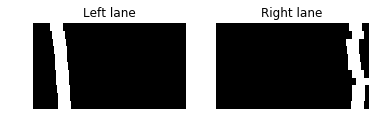

In [40]:
mask_L,mask_R = initial_mask(lane_line_gb,window_size=40)

plt.subplot(1,2,1)
plt.imshow(mask_L,cmap='gray')
plt.axis('off')
plt.title('Left lane')
plt.subplot(1,2,2)
plt.imshow(mask_R,cmap='gray')
plt.axis('off')
plt.title('Right lane');

In [41]:
# function for polynomial fit
def polyfit(line,thresh=0.5,lane_range=[5,90]):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    img_size = (line.shape[1],line.shape[0])
    vals = np.argwhere(line > thresh)
    
    all_x = vals.T[0]
    all_y = vals.T[1]
    small,large = np.percentile(all_y,lane_range)
    all_y = all_y[np.where((all_y>small) & (all_y<large))]
    all_x = all_x[np.where((all_y>small) & (all_y<large))]
    fit = np.polyfit(all_x, all_y, 2)
    
    y = np.arange(11)*img_size[1]/10
    fitx = fit[0] * y**2 + fit[1]*y + fit[2]
    fit_cr = np.polyfit(all_x*ym_per_pix, all_y*xm_per_pix, 2)
    y_eval = np.max(all_x)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
    return fitx,y,fit,curverad

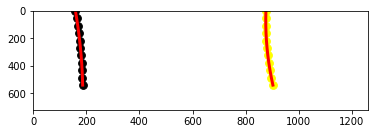

In [42]:
left_fitx , left_y, left_fit,left_curve = polyfit(mask_L,thresh=0.08,lane_range=[5,90])
right_fitx, right_y, right_fit,right_curve = polyfit(mask_R,thresh=0.008,lane_range=[5,95])
ax = plt.subplot(211)

plt.plot(left_fitx,left_y,lw=3,c="r")
plt.plot(right_fitx,right_y,lw=3,c="r")
plt.scatter(left_fitx,left_y,c="black",s=60)
plt.scatter(right_fitx,right_y,c="yellow",s=60)

plt.xlim(0,1260)
plt.ylim(0,720)
ax.invert_yaxis()

### Plot back

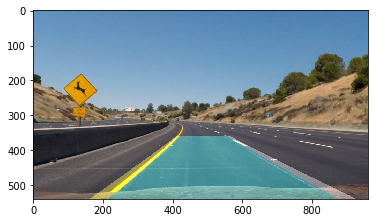

In [43]:
warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane into the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

col_L = (255,255,0)
col_R = (255,255,255)    

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_R)


newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 


result = cv2.addWeighted(image_ud, 1, newwarp, 0.3, 0)
plt.imshow(result)